In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from scipy.sparse import csc_matrix, coo_matrix, diags
import scipy as sp
from tqdm import tqdm

In [2]:
import seaserpent as ss

# reading data

In [3]:
info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',
                   delimiter = '\t')
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_71256\649695127.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [4]:
info.super_class.value_counts(dropna = False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [5]:
# to make the matrix smaller, let's take visual projection neurons as visual input, and remove the optic lobe neurons
cb = info[~info.super_class.isin(['optic'])]
# filter out the visual sensory neurons, except for the ocellar ones
cb = cb[(cb.cell_class != 'visual') | (cb.cell_type == 'ocellar retinula cell')]
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,morphology_group,top_nt,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,NaN,acetylcholine,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,VLPl2_medial__0,acetylcholine,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,NaN,acetylcholine,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,NaN,acetylcholine,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,NaN,acetylcholine,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123502,79587599823629322,720575940618417409,130350,14001,3229,NaN,NaN,NaN,NaN,afferent,...,NaN,NaN,NaN,NaN,NaN,left,OCN,fw123599,FBbt_00004242,NaN
123503,79587599823608864,720575940628941553,130046,14747,3205,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.734219,NaN,NaN,left,OCN,fw123600,FBbt_00004242,NaN
123504,79728680842360672,720575940612567258,132026,19096,3069,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.729409,NaN,NaN,center,OCN,fw123601,FBbt_00004242,NaN
123505,79798912214529467,720575940630757750,133378,17839,3166,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.544816,NaN,NaN,center,OCN,fw123602,FBbt_00004242,NaN


In [6]:
# which sensory modalities are there?
cb[cb.super_class == 'sensory']['cell_class'].value_counts()

cell_class
mechanosensory     2648
olfactory          2281
gustatory           343
visual              273
unknown_sensory     135
hygrosensory         74
thermosensory        29
Name: count, dtype: int64

In [7]:
cb["combined_type"] = cb.cell_type
# fill the leftover nas with hemibrain_type
cb.combined_type.fillna(cb.hemibrain_type, inplace= True)
cb.combined_type.value_counts()

combined_type
KCg-m           2190
KCab            1643
BM_InOm         1111
LC12             380
TmY14            370
                ... 
PS230,PLP242       1
CB1453             1
AVLP458            1
PLP243             1
DNge151            1
Name: count, Length: 8290, dtype: int64

## no type

In [8]:
# how many neurons have no type information?
cb[['cell_type','hemibrain_type']].isna().value_counts()

cell_type  hemibrain_type
True       False             20602
False      True              19691
           False              8952
True       True               1356
Name: count, dtype: int64

In [9]:
cbnotype = cb[cb.hemibrain_type.isna() & cb.cell_type.isna()]
cbnotype.status.value_counts(dropna=False)

status
NaN            1285
outlier_bio      44
outlier_seg      27
Name: count, dtype: int64

In [10]:
# which hemilineages do the neurons without a type belong to?
cbnotype[cbnotype.status.isna()].ito_lee_hemilineage.value_counts(dropna = False)

ito_lee_hemilineage
NaN                 796
SLPa&l1_anterior     59
LB0_anterior         54
putative_primary     30
VLPl1_or_VLPl5       17
                   ... 
ALv2                  1
DM2_CX_d2             1
VPNl&d1_dorsal        1
SLPav1_medial         1
FLAa3                 1
Name: count, Length: 102, dtype: int64

In [11]:
cbnotype[cbnotype.status.isna()].super_class.value_counts()

super_class
central               511
ascending             436
sensory               312
motor                  15
visual_projection       7
visual_centrifugal      4
Name: count, dtype: int64

In [12]:
cbnotype.root_id[cbnotype.ito_lee_hemilineage.isna() & (cbnotype.super_class == 'central')].values

array([720575940638707901, 720575940612376690, 720575940623883815,
       720575940619857902, 720575940616176571, 720575940631507596,
       720575940630674488, 720575940639662069, 720575940617160251,
       720575940608766933, 720575940625987390, 720575940640768419,
       720575940622287286, 720575940626042556, 720575940635906958,
       720575940623441629, 720575940615828573, 720575940641836232,
       720575940632375891, 720575940608176452, 720575940619875157,
       720575940637070191, 720575940613408563, 720575940631271235,
       720575940644377111, 720575940632850327, 720575940629801035,
       720575940620224532, 720575940642658701, 720575940637248831,
       720575940635733726, 720575940625768721, 720575940615788118,
       720575940619625665, 720575940621836246, 720575940623758669,
       720575940622324009, 720575940641284853], dtype=int64)

# Add CB types from live info?

In [ ]:
# read from info
infolive = ss.Table('info', base='main')
infodf = infolive.to_frame()
# remove not a neurons and duplicate entries
infodf = infodf[~infodf.super_class.isin(['not_a_neuron']) & ~infodf.status.isin(['bad_nucleus','not_a_neuron'])]

In [ ]:
infodfnotype = infodf[infodf.root_783.isin(cbnotype.root_id.astype(str))]
infodfnotype.cb_type.value_counts()

In [ ]:
# have a look at a few
infodfnotype[infodfnotype.cb_type == 'AN_6_22,29,36,37'].root_783.astype(np.int64).values

In [ ]:
# exclude ones with 'None' in the type name - they don't seem good
# first exclude the ones without a cb_type
infodfnotype = infodfnotype[~infodfnotype.cb_type.isna()]
infodfnotype = infodfnotype[['None' not in cbtype for cbtype in infodfnotype.cb_type]]
infodfnotype.cb_type.value_counts()

In [ ]:
infodfnotype.shape

So we can add additional labels to ~1700 neurons.

In [ ]:
cbtypes = dict(zip(infodfnotype.root_783.astype(np.int64), infodfnotype.cb_type))

In [ ]:
# fill the still leftover nas with cbtype
cb.combined_type.fillna(cb.root_id.map(cbtypes), inplace= True)

# Combine types into one column

In [13]:
# fill the still leftover nas with root ids
cb.combined_type.fillna(cb.root_id.astype(str), inplace= True)

In [14]:
typedict = dict(zip(cb.root_id, cb.combined_type))
sidedict = dict(zip(cb.root_id, cb.side))
type_super_class_dict = dict(zip(cb.combined_type, cb.super_class))
type_class_dict = dict(zip(cb.combined_type, cb.cell_class)) 
type_sub_class_dict = dict(zip(cb.combined_type, cb.cell_sub_class))

In [15]:
import platform 

if platform.system() == 'Windows': 
    conn = pd.read_feather(
        'C:/Users/44745/Downloads/syn_proof_analysis_filtered_consolidated_ntavg_783.feather')
else: 
    conn = pd.read_feather('/Users/yijieyin/Downloads/syn_proof_analysis_filtered_consolidated_783.feather')

In [16]:
# filter for the connectivity between components of the central brain
conn = conn[conn.pre_pt_root_id.isin(cb.root_id) & conn.post_pt_root_id.isin(cb.root_id)]

# add meta information
conn['pre_type'] = conn.pre_pt_root_id.map(typedict)
conn['pre_side'] = conn.pre_pt_root_id.map(sidedict)
conn['post_type'] = conn.post_pt_root_id.map(typedict)
conn['post_side'] = conn.post_pt_root_id.map(sidedict)

# and put type and side info into one column
# this separates the neurons of the same type from different sides, and
# keeps the possibility of looking at circuits where the side of the neuron makes a difference
conn['pre_type_side'] = conn.pre_type +'_'+ conn.pre_side
conn['post_type_side'] = conn.post_type +'_'+ conn.post_side
conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,pre_side,post_type,post_side,pre_type_side,post_type_side
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,0.272418,4.812546e-02,0.000472,0.000951,PLP017,right,CB3488,right,PLP017_right,CB3488_right
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,0.580512,8.166312e-04,0.000857,0.007278,LHPV6p1,right,AVLP314,right,LHPV6p1_right,AVLP314_right
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,0.001811,1.633383e-05,0.005870,0.011328,CB0960,left,CB0710,right,CB0960_left,CB0710_right
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,0.472987,9.134340e-03,0.086973,0.387136,CB0960,left,CB2317,left,CB0960_left,CB2317_left
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,0.000522,3.998458e-07,0.000103,0.000040,LAL138,left,CB2018,right,LAL138_left,CB2018_right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16847984,720575940627253510,720575940621326430,SMP_L,1,0.007995,0.983840,0.000792,9.907485e-04,0.000257,0.006124,CB1744,right,SLP134,left,CB1744_right,SLP134_left
16847990,720575940622010373,720575940634459290,VES_R,2,0.446577,0.407034,0.084707,1.664534e-03,0.007724,0.052293,DNg55,center,DNb08_a,right,DNg55_center,DNb08_a_right
16847991,720575940624054792,720575940634431935,ICL_L,5,0.012248,0.916746,0.017556,2.496850e-02,0.001025,0.027456,PVLP012,left,PVLP070,left,PVLP012_left,PVLP070_left
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,0.032063,1.844075e-03,0.028945,0.036396,PVLP007,left,AVLP089,left,PVLP007_left,AVLP089_left


In [17]:
root_typeside_dict = dict(zip(conn.pre_pt_root_id, conn.pre_type_side))
root_typeside_dict.update(dict(zip(conn.post_pt_root_id, conn.post_type_side)))

type_typeside_dict = dict(zip(conn.pre_type_side, conn.pre_type))
type_typeside_dict.update(dict(zip(conn.post_type_side, conn.post_type)))

typeside_side_dict = dict(zip(conn.pre_type_side, conn.pre_side))
typeside_side_dict.update(dict(zip(conn.post_type_side, conn.post_side)))
len(type_typeside_dict)

17807

In [18]:
# sum the number of synapses across neuropils and root_ids of the same type and side
conntt = conn.groupby(['pre_type_side', 'post_type_side', 'pre_type',
                      'post_type'])['syn_count'].sum().reset_index()
conntt

,pre_type_side,post_type_side,pre_type,post_type,syn_count
0,"(AVLP346,AVLP348)a_left","(AVLP346,AVLP348)a_left","(AVLP346,AVLP348)a","(AVLP346,AVLP348)a",3
1,"(AVLP346,AVLP348)a_left","(AVLP346,AVLP348)b_left","(AVLP346,AVLP348)a","(AVLP346,AVLP348)b",21
2,"(AVLP346,AVLP348)a_left",5-HTPLP01_left,"(AVLP346,AVLP348)a",5-HTPLP01,4
3,"(AVLP346,AVLP348)a_left",720575940621603755_left,"(AVLP346,AVLP348)a",720575940621603755,6
4,"(AVLP346,AVLP348)a_left",720575940623171308_left,"(AVLP346,AVLP348)a",720575940623171308,1
...,...,...,...,...,...
3328174,vpoEN_right,pC1d_left,vpoEN,pC1d,4
3328175,vpoEN_right,pC1d_right,vpoEN,pC1d,41
3328176,vpoEN_right,pC1e_right,vpoEN,pC1e,4
3328177,vpoEN_right,vpoEN_left,vpoEN,vpoEN,2


In [19]:
# how many neurons are there roughly?
print('Total number of unique ids: ', len(set(conn.pre_pt_root_id)))
print('Total number of unique types (including where root_ids are used as a type): ', len(set(cb.combined_type)))
print('Total number of unique type_sides: ', len(set(conn.pre_type_side)))

Total number of unique ids:  50338
Total number of unique types (including where root_ids are used as a type):  9646
Total number of unique type_sides:  17758


In [20]:
# the amount of memory it would take for a dense matrix in Gb
# number of integers * 64 bit integers / 8 bits per byte / 1e9 bytes per Gb
(len(set(conn.pre_type_side))**2)*64/8/1e9

2.522772512

- COO Matrix (Coordinate format):
1. In COO format, a sparse matrix is represented by three arrays: row indices, column indices, and the values themselves.  
2. This format is ideal for constructing sparse matrices when you have the coordinates of the non-zero elements (like from an edge list).  
3. It's efficient for matrix construction but not for matrix operations (like multiplication or indexing).  

- CSC Matrix (Compressed Sparse Column format):
1. In CSC format, the matrix is represented by column pointers, row indices, and the non-zero values.  
2. This format is efficient for arithmetic operations, column slicing, and matrix-vector products.  
3. However, constructing a CSC matrix directly from an edge list isn't as straightforward as with a COO matrix.

In [21]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(conntt.pre_type_side).union(set(conntt.post_type_side))
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node:num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conntt['pre_idx'] = conntt['pre_type_side'].map(nodes_to_idx)
conntt['post_idx'] = conntt['post_type_side'].map(nodes_to_idx)

# Create COO matrix
row = conntt['pre_idx'].values
col = conntt['post_idx'].values
data = conntt['syn_count'].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size/1e6

40.009376

In [22]:
csc.shape

(17806, 17806)

In [23]:
csc

<17806x17806 sparse matrix of type '<class 'numpy.int64'>'
	with 3328179 stored elements in Compressed Sparse Column format>

In [24]:
col_sums = csc.sum(axis=0)
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
# .A turns it from a sparse matrix into a dense np array
col_sums_with_inversion = np.reciprocal(col_sums.A.squeeze().astype(float), where=col_sums.A.squeeze() != 0)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

In [25]:
sp.sparse.save_npz('data/adult_type_inprop.npz', inprop)

# NT

In [26]:
cb.top_nt.value_counts(dropna = False)

top_nt
acetylcholine    28338
glutamate         8759
dopamine          5850
gaba              5643
serotonin         1773
NaN                146
octopamine          92
Name: count, dtype: int64

(array([8.999e+03, 5.600e+02, 0.000e+00, 5.600e+01, 0.000e+00, 2.100e+01,
        3.000e+00, 0.000e+00, 6.000e+00, 1.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

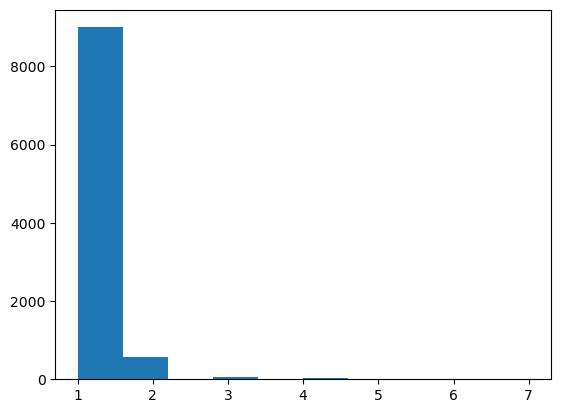

In [27]:
# first check consistency of NT within each type 
cb['top_nt'] = cb['top_nt'].fillna('unknown')
nt_count_per_type = cb.groupby('combined_type')['top_nt'].nunique()
plt.hist(nt_count_per_type)

In [28]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = cb[cb.combined_type.isin(nt_conflict_types)].groupby(['combined_type', 'top_nt']).size()

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name='counts')

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(by=['combined_type', 'counts'], ascending=[True, False], inplace=True)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(cb.combined_type, cb.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []

# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df['counts'].max()
    top_nts = df[df['counts'] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(df['combined_type'].iloc[0])  # Record the type with ties
        random_nt = np.random.choice(top_nts['top_nt'].values)
        while random_nt == 'unknown': 
            random_nt = np.random.choice(top_nts['top_nt'].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts['top_nt'].values[0]

# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts['combined_type'] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

239

In [29]:
# the types without any known nt 
[atype for atype, nt in type_nt.items() if nt == 'unknown']

['720575940638707901',
 'DNge061',
 '720575940612376690',
 'ITP',
 '720575940626896145',
 '720575940622611917',
 '720575940624156391',
 '720575940632738259',
 '720575940621636988',
 '720575940610239608',
 '720575940623382711',
 '720575940612269283',
 'AN_GNG_204',
 'AN_GNG_124',
 '720575940614957115',
 '720575940626216720',
 '720575940621463699',
 '720575940606375772',
 '720575940610183154',
 '720575940617816661',
 '720575940635901274',
 '720575940612137895',
 '720575940621568490',
 '720575940619617919',
 '720575940628335611',
 '720575940633705560',
 '720575940637470627',
 '720575940639152117',
 '720575940638909429',
 '720575940614736699',
 '720575940611937967',
 '720575940613684274',
 '720575940625771780',
 '720575940619904380',
 '720575940630846125',
 '720575940624211202',
 '720575940611477229',
 '720575940628628055',
 '720575940618759078',
 '720575940629273130',
 '720575940618109460',
 '720575940611810001',
 '720575940628268226',
 '720575940620287820',
 '720575940623758669',
 '72057

In [30]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary 
nt_value = {'acetylcholine': 1, 
           'glutamate': -1, 
           'gaba': -1, 
           'dopamine': 1, 
           'serotonin': 1, 
           'octopamine': 1, 
           'unknown': 1}

# type_sign = pd.DataFrame(type_nt.items(), columns = ['cell_type','nt'])
# type_sign['sign'] = type_sign.nt.map(nt_value)
# type_sign.to_csv('data/adult_nt.csv')

# saving meta

In [31]:
# save to csv, one row is one neuron 
meta = pd.DataFrame(root_typeside_dict.items(), columns = ['root_id','cell_type_side'])
# indices are still according to type_side 
meta['idx'] = meta.cell_type_side.map(nodes_to_idx)
meta['cell_type'] = meta.cell_type_side.map(type_typeside_dict)
meta['super_class'] = meta.cell_type.map(type_super_class_dict)
meta['cell_class'] = meta.cell_type.map(type_class_dict)
meta['cell_sub_class'] = meta.cell_type.map(type_sub_class_dict)
meta['nt'] = meta.cell_type.map(type_nt)
meta['sign'] = meta.nt.map(nt_value)
meta['side'] = meta.root_id.map(sidedict)
meta.to_csv('data/adult_meta.csv')

In [32]:
# save the meta data as a csv, one row is one type_side  
meta = pd.DataFrame(nodes_to_idx.items(), columns=['cell_type_side','idx'])
meta['cell_type'] = meta.cell_type_side.map(type_typeside_dict)
meta['super_class'] = meta.cell_type.map(type_super_class_dict)
meta['cell_class'] = meta.cell_type.map(type_class_dict)
meta['cell_sub_class'] = meta.cell_type.map(type_sub_class_dict)
meta['nt'] = meta.cell_type.map(type_nt)
meta['sign'] = meta.nt.map(nt_value)
meta['side'] = meta.cell_type_side.map(typeside_side_dict)
meta.to_csv('data/adult_type_meta.csv')

# int64 vs. int32

In [ ]:
# sensitivity analysis - does int32/16 matter?
import numpy as np
from scipy.sparse import random as sparse_random, csc_matrix

# Example matrix size
n = 100

# Generate a random sparse matrix (for demonstration purposes)
rng = np.random.default_rng()
matrix_float64 = sparse_random(n, n, density=0.1, format='csc', data_rvs=rng.random).astype(np.float64)
matrix_float32 = matrix_float64.astype(np.float32)
matrix_float16 = matrix_float64.astype(np.float16)

# Function to perform a series of matrix multiplications
def multiply_matrix(matrix, steps):
    result = matrix
    for _ in range(steps):
        result = result @ matrix
    return result

# Perform the operations
steps = 5
result_64 = multiply_matrix(matrix_float64, steps)
result_32 = multiply_matrix(matrix_float32, steps)
result_16 = multiply_matrix(matrix_float16, steps)

# Compare the results
diff_64_32 = np.abs(result_64 - result_32.astype(np.float64))
diff_64_16 = np.abs(result_64 - result_16.astype(np.float64))

# Print maximum differences
print(f"Max difference between float64 and float32: {diff_64_32.max()}")
print(f"Max difference between float64 and float16: {diff_64_16.max()}")

So we need float32.

# parallelising vs. not

In [ ]:
import multiprocessing
import time

import numpy as np

In [ ]:
num_cores = multiprocessing.cpu_count()

In [ ]:
# Define the matrix multiplication function
def matrix_multiply(args):
    A, B = args
    return np.dot(A, B)

In [ ]:
# Create two random matrices of size 1000x1000
A = np.random.rand(1000, 1000)
B = np.random.rand(1000, 1000)

# Split the matrices into 4 parts
A_parts = np.array_split(A, 4, axis=1)
B_parts = np.array_split(B, 4)

In [ ]:
from concurrent.futures import ProcessPoolExecutor


In [ ]:
start = time.time()

# # Map the matrix multiplication function to the 4 parts of the matrices
# C_parts = pool.map(matrix_multiply,
#                    [(A_part, B_part) for A_part, B_part in zip(A_parts, B_parts)])
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(matrix_multiply, A_part, B_part) for A_part, B_part in zip(A_parts, B_parts)]
    C_parts = [f.result() for f in futures]

# Concatenate the parts of the result matrix
C = np.concatenate(C_parts, axis=1)

end = time.time()
print(end - start)